# Binary Prediction - Kaggle Rainfall Dataset
## Author: Max Rong

Description: This project is from Kaggle's playground series(Playground Series - Season 5, Episode 3). As it's name indicates, the project aims to predict rainfall for a particular day in the year based off a training dataset provided by kaggle.

Todo:
- Better Data Preprocessing 
    - [ ] Research Data Preprocessing methods - normalization, scaling, etc.
    - Feature Engineering
        - [ ] Add week feature(week of the year, 1-52)
        - [ ] Add autoregressive feature(previous value of rainfall, pressure change, temp change)
        - [ ] Research more possible features
            - How can I utilize maxtemp?
            - Stormfront? with cloud, sunshine, winddirection, windspeed
            - pressure change? Does it relate to rain
            - Humidity with dewpoint, does "wetness" relate to rain?
- Improve data visualization
    - [ ] Clean up correlation plot
    - [ ] Add legend to rainfall count plot by month
    - [ ] Add legend to rainfall count plot by season
    - [ ] More plots?
- Model Training
    - TBA

Notes: 
- Current features:
    id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month,season,year


# Importing Libraries

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

# Data Prep

In [94]:
# load dataframe
weather_df = pd.read_csv("datasets/train.csv")
print("df dimensions:", weather_df.shape)

# Clean data
remove_bad_rows(weather_df)

# Check for leap years before adding features
print("Checking for leap years:", weather_df.loc[weather_df['day']==366].index) # No leap years found\
    
# Add Features(work becomes a lot easier without leap years)
add_month(weather_df)
add_season(weather_df)
add_year(weather_df)

# Print DF
print(weather_df.head())
print(weather_df.tail())

df dimensions: (2190, 13)
Checking for leap years: Index([], dtype='int64')
   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  month  season  year  
0   88.0       1.1           60.0       17.2         1      1       1     1  
1   91.0       0.0           50.0       21.9         1      1       1     1  
2   47.0       8.3           70.0       18.1         1      1       1     1  
3   95.0       0.0           60.0       35.6         1      1       1     1  
4   45.0       3.6           40.0       24.8         0      1       1     1  
     

## Feature Creation

In [ ]:
# dropna values, drop duplicates, reset index to remove gaps
def remove_bad_rows(df):
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

# Add month column to df
def add_month(df):
    df['month'] = df['day'].apply(day_to_month)  

# Add season column to df
def add_season(df):
    df['season'] = df['month'].apply(month_to_season) 

# Convert day index(1-31) to month index(1-12)
def day_to_month(x):
    # map the day that corresponds to the end of each month(1-12)
    cutoffs = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
    for i in range(len(cutoffs)):
        if x <= cutoffs[i]:
            return (i+1)

# Convert month index(1-12) to seasons index(1-4)
def month_to_season(month):
    # map each month to a season
    lookup = {
        12: 1, 1: 1, 2: 1,    # winter
        3: 2, 4: 2, 5: 2,     # spring
        6: 3, 7: 3, 8: 3,     # summer
        9: 4, 10: 4, 11: 4    # fall
    }
    return lookup[month]

# Add year column to df
def add_year(df):
    # In this case, we can assume each id corresponds to a specific day
    # Thus we can classify id = total days since beginning observation
    # So we use id to get year
    df['year'] = df['id'].apply(lambda x: (x//365)+1)

## Visualize data

<Axes: xlabel='month', ylabel='count'>

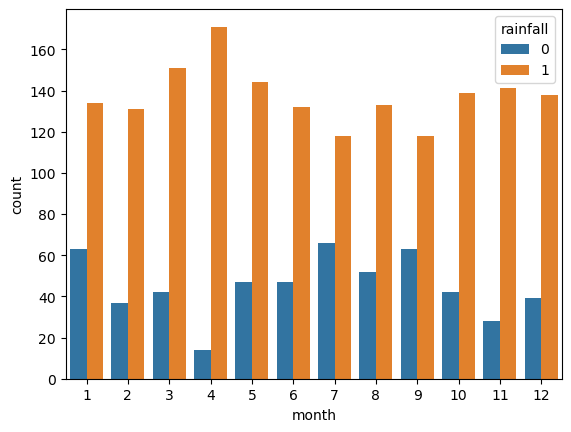

In [95]:
# Rainfall Count by Month

sns.countplot(x='month', hue='rainfall', data=weather_df)

<Axes: xlabel='season', ylabel='count'>

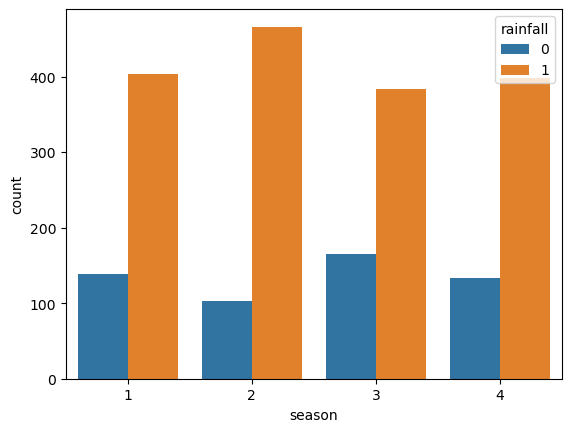

In [96]:
# Rainfall Count by Season

sns.countplot(x='season', hue='rainfall', data=weather_df)

<Axes: >

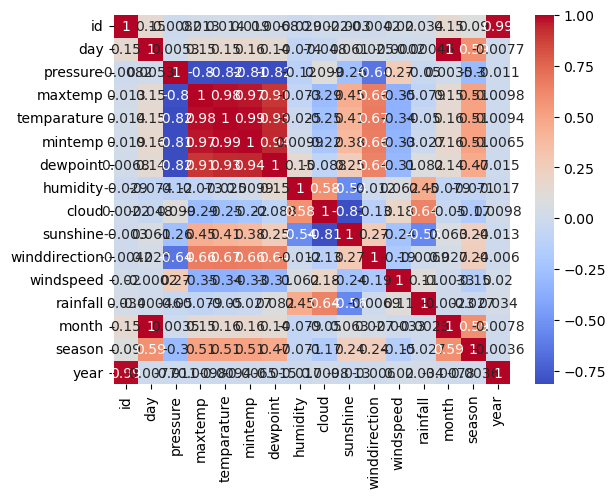

In [97]:
# Correlation heatmap

sns.heatmap(weather_df.corr(), cmap='coolwarm', annot=True)


# Model Training